In [2]:
import pandas as pd

# Load CSV
df = pd.read_csv('synthetic_battery_prediction_data.csv')

# Features and targets
feature_cols = ['temperature', 'voltage', 'current', 'power', 'delta_temp', 'delta_voltage', 'delta_current']
target_cols = ['temperature_next', 'voltage_next', 'current_next']

X = df[feature_cols].values
y = df[target_cols].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1999, 7)
y shape: (1999, 3)


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv('synthetic_battery_prediction_data.csv')

# Features and targets
feature_cols = ['temperature', 'voltage', 'current', 'power', 'delta_temp', 'delta_voltage', 'delta_current']
target_cols = ['temperature_next', 'voltage_next', 'current_next']

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform
X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[target_cols])


In [4]:
import numpy as np

seq_length = 10  # number of timesteps per sequence

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # predict next step after the sequence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

print("X_seq shape:", X_seq.shape)  # (num_samples, seq_length, num_features)
print("y_seq shape:", y_seq.shape)  # (num_samples, num_targets)


X_seq shape: (1989, 10, 7)
y_seq shape: (1989, 3)


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=600, shuffle=False)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Split into train/test
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
import torch.nn as nn

class BatteryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BatteryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)          # out: [batch, seq_len, hidden]
        out = out[:, -1, :]            # take last timestep
        out = self.fc(out)
        return out

input_size = X_seq.shape[2]   # number of features
hidden_size = 64
num_layers = 2
output_size = y_seq.shape[1]  # number of targets

model = BatteryLSTM(input_size, hidden_size, num_layers, output_size)


In [8]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # learning rate = 0.001
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.6f}")


Epoch 1/20, Loss: 0.073655
Epoch 2/20, Loss: 0.005121
Epoch 3/20, Loss: 0.002498
Epoch 4/20, Loss: 0.001535
Epoch 5/20, Loss: 0.000867
Epoch 6/20, Loss: 0.000640
Epoch 7/20, Loss: 0.000563
Epoch 8/20, Loss: 0.000509
Epoch 9/20, Loss: 0.000456
Epoch 10/20, Loss: 0.000436
Epoch 11/20, Loss: 0.000427
Epoch 12/20, Loss: 0.000391
Epoch 13/20, Loss: 0.000368
Epoch 14/20, Loss: 0.000357
Epoch 15/20, Loss: 0.000342
Epoch 16/20, Loss: 0.000332
Epoch 17/20, Loss: 0.000333
Epoch 18/20, Loss: 0.000305
Epoch 19/20, Loss: 0.000318
Epoch 20/20, Loss: 0.000327


In [9]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        predictions.append(outputs.numpy())
        actuals.append(yb.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Inverse scale to original units
predictions_orig = scaler_y.inverse_transform(predictions)
actuals_orig = scaler_y.inverse_transform(actuals)

# RMSE
rmse = np.sqrt(np.mean((predictions_orig - actuals_orig)**2, axis=0))
print("RMSE for [temperature, voltage, current]:", rmse)


RMSE for [temperature, voltage, current]: [1.2051051e+01 8.2287081e-03 1.4542696e-02]


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# predictions_orig and actuals_orig from previous code
rmse = np.sqrt(mean_squared_error(actuals_orig, predictions_orig, multioutput='raw_values'))
mae = mean_absolute_error(actuals_orig, predictions_orig, multioutput='raw_values')
r2 = r2_score(actuals_orig, predictions_orig, multioutput='raw_values')

print("Temperature, Voltage, Current Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Temperature, Voltage, Current Metrics:
RMSE: [1.2051051e+01 8.2287081e-03 1.4542696e-02]
MAE: [9.613270e+00 6.767940e-03 1.158386e-02]
R²: [0.9996058  0.9992143  0.98947626]


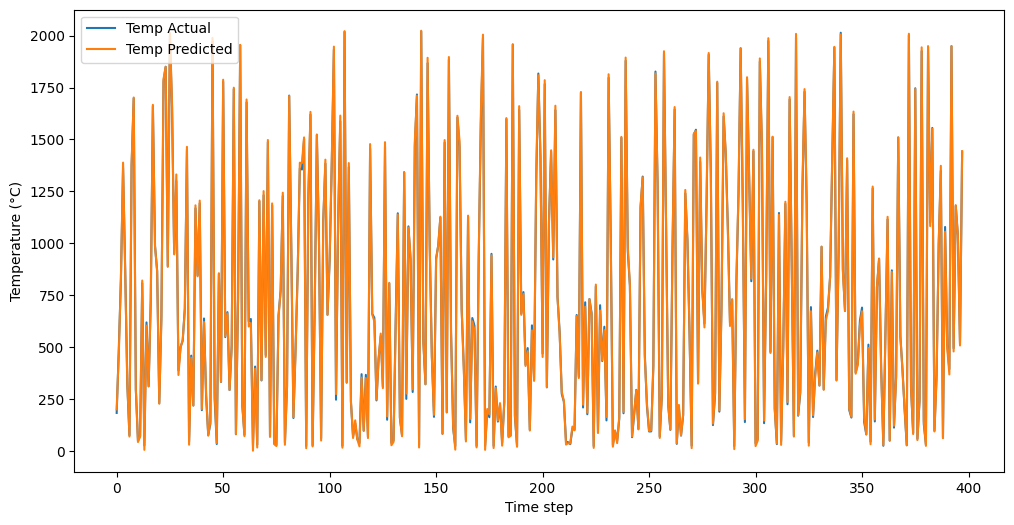

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_orig[:, 0], label='Temp Actual')
plt.plot(predictions_orig[:, 0], label='Temp Predicted')
plt.xlabel('Time step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()
